In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import time
import math
import os
import json
from pathlib import Path

dtype = torch.float
device_data = torch.device('cpu')
device_test = torch.device('cuda:0')
# evaluate the model by calculating the MSE of each curve
def evaluate(model, Input, Output):
    model.eval()
    with torch.no_grad():
        Output_pred = model(Input)
        loss_mat = (Output_pred - Output) ** 2
        loss = torch.mean(loss_mat, dim=1)
        return loss.cpu().numpy(), Output_pred.cpu().numpy()

In [11]:
model_folder = Path(r'.\nets\fnet\BASELINE_L20_R5.0_T150-400_NOISELESS')

fnet = torch.load(model_folder/'fnet.pkl')

fnet.to(device_test)

with open(model_folder/'config.json',encoding='utf-8') as f:
    config = json.load(f)

train_data_path = Path(r'data\coatings\L20_R5.0_T10-400_1M.mat')
test_data_path = Path(r'data\coatings\L20_R5.0_T10-400_50K.mat')

fc = config['fnet']

wl = np.arange(fc['StartWL'], fc['EndWL'], fc['Resolution'])


train_data = scio.loadmat(train_data_path)
Input_train = torch.tensor(train_data['d'][:fc['TestingDataSize']], device=device_data, dtype=dtype)
Output_train = torch.tensor(train_data['T'][:fc['TestingDataSize']], device=device_data, dtype=dtype)

test_data = scio.loadmat(test_data_path)
Input_test = torch.tensor(test_data['d'], device=device_data, dtype=dtype)
Output_test = torch.tensor(test_data['T'], device=device_data, dtype=dtype)


In [12]:
test_loss, test_Output_pred = evaluate(fnet, Input_test.to(device_test), Output_test.to(device_test))
train_loss, train_Output_pred = evaluate(fnet, Input_train.to(device_test), Output_train.to(device_test))
print('train loss: ', np.mean(train_loss))
print('test loss: ', np.mean(test_loss))


train loss:  0.11147923
test loss:  0.11138449


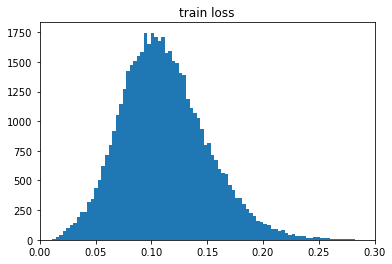

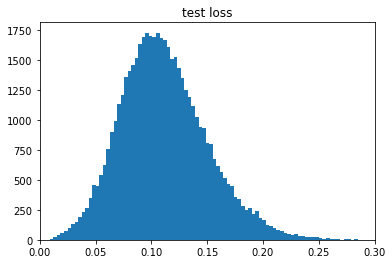

In [13]:
plt.hist(train_loss, bins=100)
plt.xlim(0, 0.3)
plt.title('train loss')
plt.show()
plt.hist(test_loss, bins=100)
plt.xlim(0, 0.3)
plt.title('test loss')
plt.show()

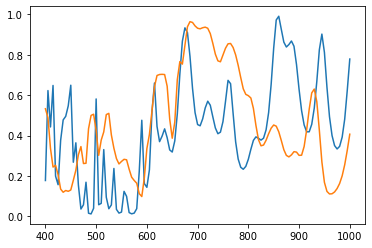

In [14]:
worst = np.argmin(test_loss)+1
plt.plot(wl,Output_test[worst].cpu().numpy())
plt.plot(wl,test_Output_pred[worst])

In [71]:
Input_test[worst].sum()

tensor(2771.4875)

In [68]:
diff = np.abs(train_data['T'][1:] - train_data['T'][:-1])
std = np.std(train_data['T'], axis=1)
print(np.mean(diff),np.mean(std))

0.30709544 0.26836726


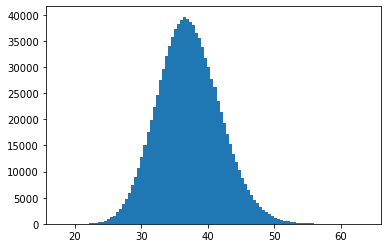

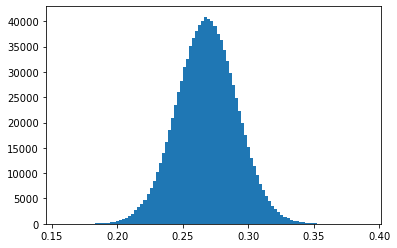

In [69]:
plt.hist(diff.sum(axis=1),bins=100)
plt.show()
plt.hist(std,bins=100)
plt.show()

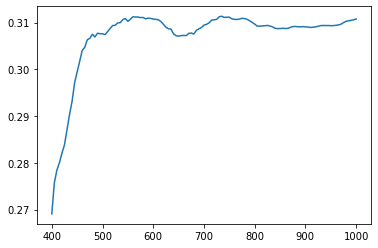

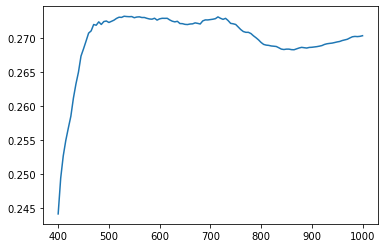

In [70]:
plt.plot(wl, diff.mean(axis=0))
plt.show()
plt.plot(wl, np.std(train_data['T'], axis=0))
plt.show()